In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags


In [5]:
def V(x, alpha):
    return alpha*x**4 - 2*x**2 + 1/alpha

In [6]:
alpha = 0.4
h_bar = 1
m = 1

Problem A

$E_0 \approx \left\langle \frac{m}{2\,\delta\tau}\,(x_{i+1} - x_i)^2 + \delta\tau\,V\!\Bigl(\frac{x_i + x_{i+1}}{2}\Bigr)\right\rangle = KE + U$


In [11]:
#Tested Parameters
N = 1000 # need test increasing initial config
tau_b = 5 # need test 10， 15， 20 large_tau_b
burn_in_steps = 2000
num_sweep = 20000
hit_size = 0.4 #general： from 0.4 to 0.7
thinning = 10

In [16]:
#Idea comes from: S. Mittal, M. J. Westbroek, P. R. King, and D. D. Vvedensky, “Path integral Monte Carlo method for the quantum anharmonic oscillator”, Eur. J. Phys. 41, 055401 (2020).
#2] R. Rodgers and L. Raes, Monte Carlo simulations of harmonic and anharmonic oscillators in discrete Euclidean time, DESY Summer Student Programme (2014).

# x_i - x_{i-1}
# return delta_E
def delta_action(x_path, i, x_new, m, dtau):
    N = len(x_path)
    i_minus = (i - 1) % N
    i_plus  = (i + 1) % N

    x_old = x_path[i]

    # old local: Kinetic + potential midpoint
    kin_old = (m/(2*dtau))*((x_path[i_plus] - x_old)**2
                           + (x_old - x_path[i_minus])**2)
    pot_old = dtau*( V(0.5*(x_old + x_path[i_plus]),alpha)
                   + V(0.5*(x_path[i_minus] + x_old),alpha) )

    # new local: Kinetic + potential
    kin_new = (m/(2*dtau))*((x_path[i_plus] - x_new)**2
                           + (x_new - x_path[i_minus])**2)
    pot_new = dtau*( V(0.5*(x_new + x_path[i_plus]), alpha)
                   + V(0.5*(x_path[i_minus] + x_new), alpha) )

    return (kin_new + pot_new) - (kin_old + pot_old)

In [20]:
def metropolis_mcmc(N, tau_b, m, num_sweep,
                    burn_in_steps, hit_size, thinning):
    dtau = tau_b / N
    # in paper Rodgers & Raes， in Mittal change step size into param.
    #hit_size = 2.0 * np.sqrt(dtau)

    x_path = np.zeros(N)

    E_list = []
    all_x_data = []
    accepted = 0

    for sweep in range(num_sweep):
        for i in range(N):
            x_old = x_path[i]
            x_prop = x_old + np.random.uniform(-hit_size, hit_size)

            dS = delta_action(x_path, i, x_prop, m, dtau)

            if dS < 0:
                accept = True
            else:
                r = np.random.rand()
                accept = (r < np.exp(-dS))

            if accept:
                x_path[i] = x_prop
                accepted += 1
                
        if sweep > burn_in_steps and ((sweep - burn_in_steps) % thinning == 0):
            # measure energy
            kin_sum = 0.0
            pot_sum = 0.0
            for i in range(N):
                i_plus = (i + 1) % N
                kin_sum += (m/(2*dtau)) * (x_path[i_plus]-x_path[i])**2
                pot_sum += V(0.5*(x_path[i_plus]+x_path[i]), alpha)
            E_sample = (kin_sum + dtau*pot_sum) / N
            E_list.append(E_sample)

            all_x_data.extend(x_path)

    accept_rate = accepted / (num_sweep*N)
    return E_list, all_x_data, accept_rate

In [22]:
E_list, all_x_data, arate = metropolis_mcmc(
        N=N, tau_b=tau_b, m=m,
        num_sweep=num_sweep, burn_in_steps=burn_in_steps,
        thinning=thinning, hit_size=hit_size
    )

alpha = 0.4
Acceptance rate: 19.9%
Estimated ground state energy ~ 0.5080 ± 0.0005


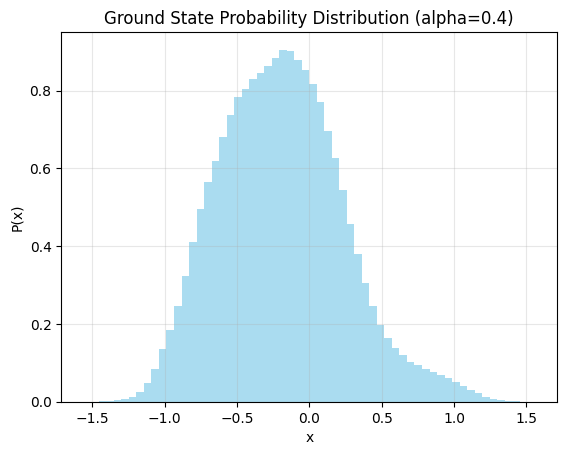

In [23]:
E_mean = np.mean(E_list)
E_err  = np.std(E_list)/np.sqrt(len(E_list))

print(f"alpha = {alpha}")
print(f"Acceptance rate: {arate*100:.1f}%")
print(f"Estimated ground state energy ~ {E_mean:.4f} ± {E_err:.4f}")

plt.hist(all_x_data, bins=60, density=True, alpha=0.7, color='skyblue')
plt.title(f"Ground State Probability Distribution (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(alpha=0.3)
plt.show()

In [24]:
#Tested Parameters
N = 2000 # need test increasing initial config
tau_b = 10 # need test 10， 15， 20 large_tau_b
burn_in_steps = 5000
num_sweep = 20000
hit_size = 0.4 #general： from 0.4 to 0.7
thinning = 10

In [25]:
E_list, all_x_data, arate = metropolis_mcmc(
        N=N, tau_b=tau_b, m=m,
        num_sweep=num_sweep, burn_in_steps=burn_in_steps,
        thinning=thinning, hit_size=hit_size
    )

alpha = 0.4
Acceptance rate: 19.9%
Estimated ground state energy ~ 0.5101 ± 0.0004


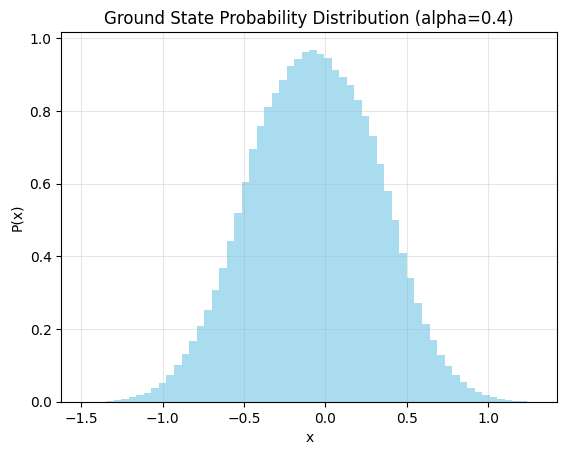

In [26]:
E_mean = np.mean(E_list)
E_err  = np.std(E_list)/np.sqrt(len(E_list))

print(f"alpha = {alpha}")
print(f"Acceptance rate: {arate*100:.1f}%")
print(f"Estimated ground state energy ~ {E_mean:.4f} ± {E_err:.4f}")

plt.hist(all_x_data, bins=60, density=True, alpha=0.7, color='skyblue')
plt.title(f"Ground State Probability Distribution (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(alpha=0.3)
plt.show()

In [27]:
#Tested Parameters
N = 500 # need test increasing initial config
# For large N, it takes a lot of time to process
tau_b = 10 # need test 10， 15， 20 large_tau_b
burn_in_steps = 5000
num_sweep = 20000
hit_size = 0.4 #general： from 0.4 to 0.7
thinning = 10

In [28]:
E_list, all_x_data, arate = metropolis_mcmc(
        N=N, tau_b=tau_b, m=m,
        num_sweep=num_sweep, burn_in_steps=burn_in_steps,
        thinning=thinning, hit_size=hit_size
    )

alpha = 0.4
Acceptance rate: 39.1%
Estimated ground state energy ~ 0.5254 ± 0.0008


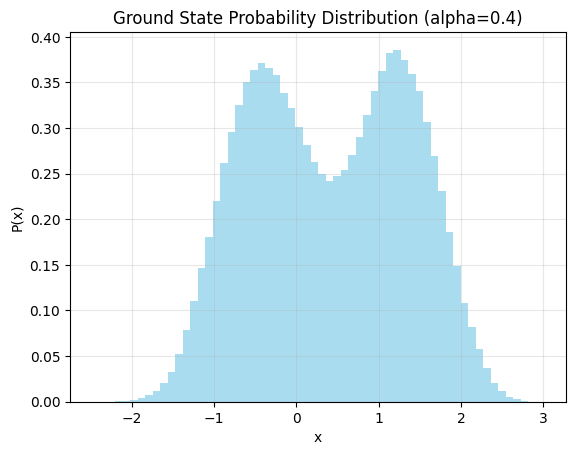

In [29]:
E_mean = np.mean(E_list)
E_err  = np.std(E_list)/np.sqrt(len(E_list))

print(f"alpha = {alpha}")
print(f"Acceptance rate: {arate*100:.1f}%")
print(f"Estimated ground state energy ~ {E_mean:.4f} ± {E_err:.4f}")

plt.hist(all_x_data, bins=60, density=True, alpha=0.7, color='skyblue')
plt.title(f"Ground State Probability Distribution (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(alpha=0.3)
plt.show()

In [30]:
#Tested Parameters
# I decreased hit_size to make sure it is not too large than 10/2000 = 0.005， which can increase the acceptance rate
N = 2000 # need test increasing initial config
tau_b = 10 # need test 10， 15， 20 large_tau_b
burn_in_steps = 5000
num_sweep = 20000
hit_size = 0.2 #general： from 0.4 to 0.7
thinning = 10

In [31]:
E_list, all_x_data, arate = metropolis_mcmc(
        N=N, tau_b=tau_b, m=m,
        num_sweep=num_sweep, burn_in_steps=burn_in_steps,
        thinning=thinning, hit_size=hit_size
    )

alpha = 0.4
Acceptance rate: 39.1%
Estimated ground state energy ~ 0.5084 ± 0.0004


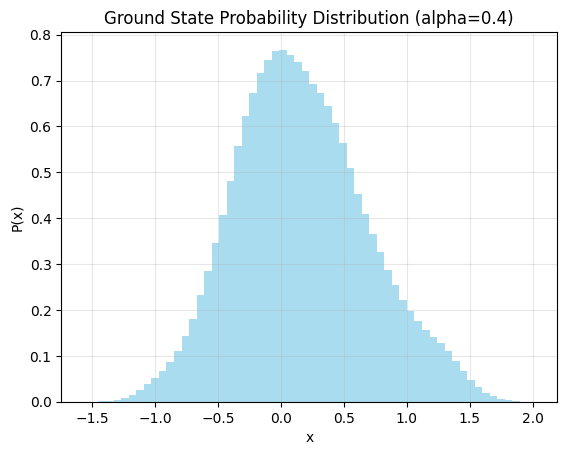

In [32]:
E_mean = np.mean(E_list)
E_err  = np.std(E_list)/np.sqrt(len(E_list))

print(f"alpha = {alpha}")
print(f"Acceptance rate: {arate*100:.1f}%")
print(f"Estimated ground state energy ~ {E_mean:.4f} ± {E_err:.4f}")

plt.hist(all_x_data, bins=60, density=True, alpha=0.7, color='skyblue')
plt.title(f"Ground State Probability Distribution (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(alpha=0.3)
plt.show()

In [33]:
#Tested Parameters: Looks the best param
# I decreased hit_size to make sure it is not too large for 10/2000 = 0.005， which can increase the acceptance rate
N = 4000 # need test increasing initial config
tau_b = 20 # need test 10， 15， 20 large_tau_b
burn_in_steps = 5000
num_sweep = 20000
hit_size = 0.1 #general： from 0.4 to 0.7
thinning = 10

alpha = 0.4
Acceptance rate: 63.1%
Estimated ground state energy ~ 0.5088 ± 0.0003


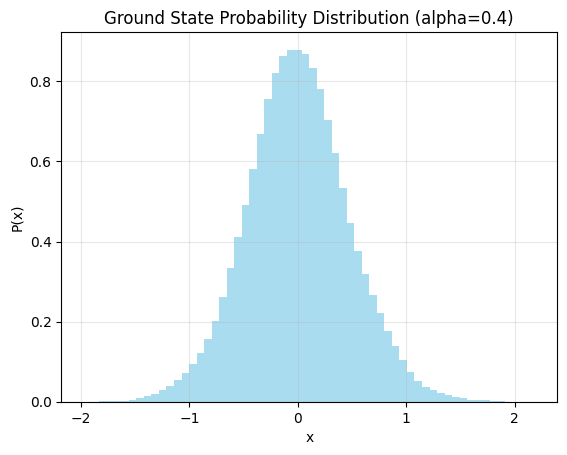

In [34]:
E_list, all_x_data, arate = metropolis_mcmc(
        N=N, tau_b=tau_b, m=m,
        num_sweep=num_sweep, burn_in_steps=burn_in_steps,
        thinning=thinning, hit_size=hit_size
    )

E_mean = np.mean(E_list)
E_err  = np.std(E_list)/np.sqrt(len(E_list))

print(f"alpha = {alpha}")
print(f"Acceptance rate: {arate*100:.1f}%")
print(f"Estimated ground state energy ~ {E_mean:.4f} ± {E_err:.4f}")

plt.hist(all_x_data, bins=60, density=True, alpha=0.7, color='skyblue')
plt.title(f"Ground State Probability Distribution (alpha={alpha})")
plt.xlabel("x")
plt.ylabel("P(x)")
plt.grid(alpha=0.3)
plt.show()

Problem B:

